In [1]:
import pystan
import pandas as pd
import numpy as np
from scipy import stats

import matplotlib.pyplot as plt
import arviz

### Introduction

**Goal**: use data consisting of the scores for all games from the 2014 world cup to estimate team ability. The data used is before the final was played so the model could be used to predict who would win the final.

Gelman's world cup model for the 2014 football world cup was written up as two posts. [Attempt 1](https://statmodeling.stat.columbia.edu/2014/07/13/stan-analyzes-world-cup-data/) built several models to estimate the difference in score between two teams at the world cup (well, actually the square root of the scores but we'll ignore that for now). This model had problems in that when using the fitted model to estimate the 95% intervals for the score differences for the world cup games on which the model was fit, more than 5% of the games fell outside of these 95% intervals. This was due to a bug in how Gelman implemented the model which he then fixed and wrote about it in [attempt 2](https://statmodeling.stat.columbia.edu/2014/07/15/stan-world-cup-update/).

Gelman also has a nice [video](https://www.youtube.com/watch?v=T1gYvX5c2sM) where he introduces this model.

### Data

The data consists of the scores for all games from the 2014 world cup up to but excluding the final and 3rd/4th place play-off.

Gelman also uses a version of the [Soccer Power Index](https://projects.fivethirtyeight.com/global-club-soccer-rankings/) for international teams which is just treated in the model as a rank order (not a score) - I can't seem to find. 

### The model

We model the score difference when team $i$ plays team $j$ as $y_{ij}$:

$$y_{ij} \sim \mathcal{t}_{\nu}\, (a_i - a_j, \sigma_y)$$

which is a student-t distribution with $\nu = 7$ degrees of freedom, location $a_i - a_j$ and shared scale $\sigma_y$.

The skill-level parameter $a_i$ of the $i$th team is modelled as:

$$a_i \sim \mathcal{N}(\mu + b \, s_i, \sigma_a)$$

where $s_i$ is the Soccer Power Index for the $i$th team and is used as prior knowledge about the abilities of the teams. This is thus a hierarchical model with each $a_i$ coming from a population level ability distribution. 

However, we care about the *relative* ability of the teams and as $\mu$ is the average of all team's abilities and we are going to compare $a_i$ to $a_j$ for any $i$ and $j$ the $\mu$s will cancel and so we can just set it to 0.

So we instead think of each $a_i$ as the relative ability of a team (relative to the population) and it is modelled as:

$$a_i \sim \mathcal{N}(b \, s_i, \sigma_a)$$

**What do the parameters represent?**

Now we have the model let's quickly explain what the parameters represent:

* $b$: the weight of the prior information in the Soccer Power Index. If this index contains no information we would expect $b$ to be close to 0.
* $\sigma_a$: the residual error in the estimates of team's abilities (as even given the Soccer Power Index we do not expect to be able to estimate ability perfectly).
* $\sigma_y$: the observational residual error - given the relative abilities of the teams we expect errors in our score difference estimates.
* $a_i$: this is the relative ability of each team to the population.

### Load data

In [13]:
teams = np.loadtxt("../data/soccerpowerindex.txt", dtype=str)
num_teams = len(teams)

prior_score = np.arange(32, 0, -1)
prior_score = (prior_score - np.mean(prior_score)) / (
    2 * np.std(prior_score, ddof=1)
)

In [14]:
data2012 = pd.read_csv(
    "../data/worldcup2012.txt", delim_whitespace=True, header=None
)
data2012.columns = ["team_1", "team_1_score", "team_2", "team_2_score"]
num_games = len(data2012)

In [15]:
team_1_rank = np.array(
    [np.argwhere(s == teams)[0][0] + 1 for s in data2012["team_1"]]
)
team_2_rank = np.array(
    [np.argwhere(s == teams)[0][0] + 1 for s in data2012["team_2"]]
)
team_1_score = data2012["team_1_score"].values
team_2_score = data2012["team_2_score"].values
score_diffs = team_1_score - team_2_score

In [16]:
degrees_of_freedom = 7

### Stan model

In [17]:
data = {
    "num_teams": num_teams,
    "num_games": num_games,
    "team_1_rank": team_1_rank,
    "team_1_score": team_1_score,
    "team_2_rank": team_2_rank,
    "team_2_score": team_2_score,
    "prior_score": prior_score,
    "deg_freedom": degrees_of_freedom,
}

In [7]:
model = pystan.StanModel(file="../stan_models/worldcup-no-sqrt.stan")

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_b0690c98284e03656f6c1e890a26458d NOW.


In [18]:
fit = model.sampling(data=data)
params = fit.extract(permuted=True)
print(fit)

Inference for Stan model: anon_model_b0690c98284e03656f6c1e890a26458d.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

            mean se_mean     sd   2.5%    25%    50%     75%  97.5%  n_eff   Rhat
b           1.25  4.6e-3   0.27   0.72   1.07   1.25    1.42    1.8   3493    1.0
sigma_a     0.31  6.4e-3    0.2   0.02   0.15    0.3    0.45   0.73    964    1.0
sigma_y     1.29  2.9e-3   0.16   1.01   1.18   1.28    1.39   1.63   2848    1.0
raw_a[1]   -0.08    0.01   0.91  -1.88  -0.68  -0.09     0.5   1.77   5535    1.0
raw_a[2]   -0.07    0.01   0.91  -1.84  -0.67  -0.07    0.52   1.69   5710    1.0
raw_a[3]    0.36    0.01   0.93   -1.5  -0.23   0.36    0.99   2.16   4158    1.0
raw_a[4]   -0.43    0.02    1.0  -2.34  -1.12  -0.44    0.26   1.56   3771    1.0
raw_a[5]    0.02    0.01   0.92  -1.81  -0.59   0.03    0.64   1.84   5368    1.0
raw_a[6]    0.33    0.01   0.89  -1.43  -0.27   0.35    0.95   1.99   519

In [19]:
arviz_inf = arviz.convert_to_inference_data(fit)
summary_df = (
    arviz.summary(arviz_inf)
    .reset_index()
    .rename(columns={"index": "parameter"})
)

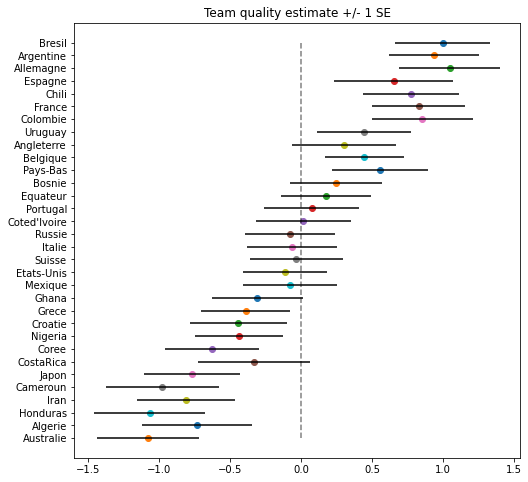

In [20]:
fig, ax = plt.subplots(figsize=(8, 8))
for i in range(num_teams):
    a_mean = params["a"][:, i].mean()
    a_sd = float(summary_df.loc[summary_df["parameter"] == f"a[{i}]", "sd"])

    ax.scatter(a_mean, i + 1)
    ax.hlines(i + 1, a_mean - a_sd, a_mean + a_sd)
plt.vlines(0, 1, num_teams, linestyle="--", alpha=0.5)
plt.gca().invert_yaxis()
# plt.xlim(-.6, .6);
plt.yticks(range(1, num_teams + 1), teams)
plt.title("Team quality estimate +/- 1 SE");

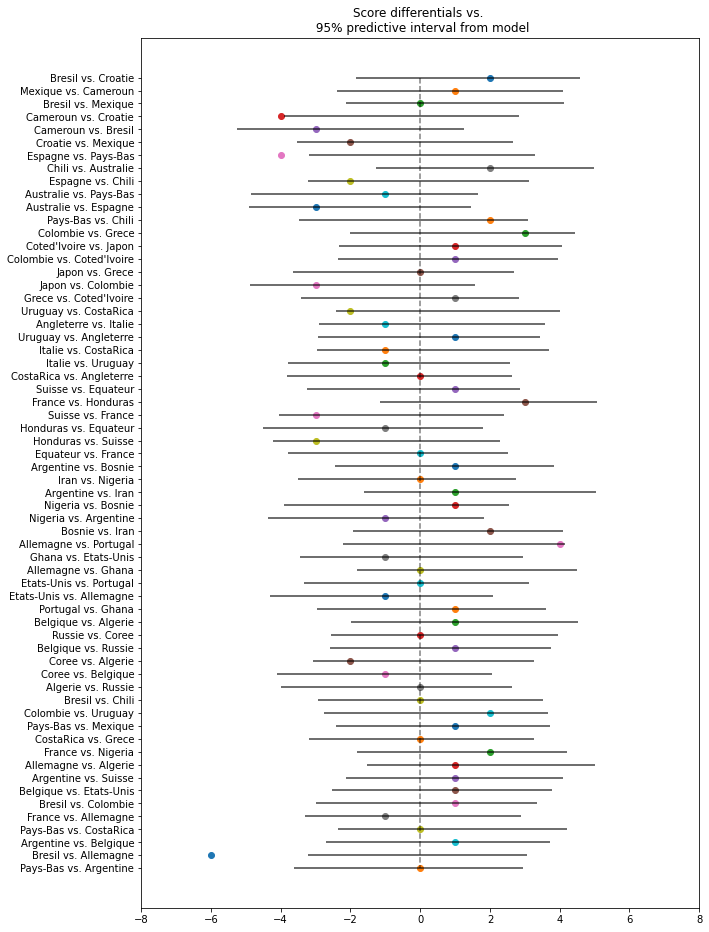

In [29]:
q = 0.95
outside_interval = 0

games = [
    f"{a} vs. {b}"
    for a, b in zip(data2012["team_1"].values, data2012["team_2"].values)
]
fig, ax = plt.subplots(figsize=(10, 16))
for i in range(num_games):
    lq, uq = np.quantile(
        params["ypred"][:, i], q=[(1 - q) / 2, q + (1 - q) / 2]
    )
    ax.scatter(score_diffs[i], i + 1)
    ax.hlines(i + 1, lq, uq, alpha=0.75)
    if score_diffs[i] > uq or score_diffs[i] < lq:
        outside_interval += 1
plt.vlines(0, 1, num_games, linestyle="--", alpha=0.5)
plt.gca().invert_yaxis()
plt.xlim(-8, 8)
plt.yticks(range(1, num_games + 1), games)
plt.title(
    f"Score differentials vs. \n {q*100:.0f}% predictive interval from model"
);